In [1]:
import quandl
import pandas as pd
import numpy as np
import talib
import csv
import warnings
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from functools import total_ordering
from testing import test_model_mapping,series_merge
from trading import generate_signals, eval_signals,time_series_chart
from commodities import hard_tech,hard,hard_pct
from pandas.plotting import register_matplotlib_converters
from testing import *
register_matplotlib_converters()

In [7]:
df_hmm=pd.read_csv('hmm_results.csv').set_index("Date")

In [8]:
df_hmm

,gold,oil,silver,ruth,irid,pall,rhod,plat
Date,,,,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,1.005238,0.949355,1.008197,1.000000,1.000000,1.002513,1.000000,0.988294
2015-01-06,1.016960,0.910091,1.023644,0.965517,1.000000,1.006281,1.000000,0.983394
2015-01-07,1.024758,0.896624,1.007881,0.965517,1.000000,1.006281,0.979920,0.979350
2015-01-08,1.020695,0.898649,1.010021,0.965517,1.000000,0.999984,0.971888,0.976142
...,...,...,...,...,...,...,...,...
2020-04-21,1.425030,14.566998,1.220299,4.655172,2.916667,2.654843,7.068273,1.257283
2020-04-22,1.423573,6.833900,1.251896,4.655172,2.916667,2.654843,6.506024,1.209190
2020-04-23,1.446264,6.122453,1.219462,4.655172,2.916667,2.654843,6.586345,1.193280


In [9]:
df_q=pd.read_csv('q_results.csv').set_index("Date")

In [10]:
df_q

,gold,oil,silver,ruth,irid,pall,rhod,plat
Date,,,,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.00000,1.0000,1.00000,1.00000,1.00000
2015-01-05,1.000000,0.999473,0.999841,1.00000,1.0000,1.00000,1.00000,1.00000
2015-01-06,1.000000,0.999473,1.000001,1.00000,1.0000,0.99202,1.00000,0.98790
2015-01-07,0.987924,0.999953,1.000001,0.99944,1.0000,0.98401,1.00000,1.00006
2015-01-08,0.987924,0.999953,1.000001,1.00000,1.0000,0.99200,1.00000,0.98785
...,...,...,...,...,...,...,...,...
2020-04-21,0.246847,0.999394,1.000242,1.02845,1.1259,0.19095,1.12815,0.99692
2020-04-22,0.263769,0.999394,1.000242,1.03115,1.1259,0.19095,1.12815,0.99692
2020-04-23,0.263769,0.999394,1.000242,1.03115,1.1259,0.19095,1.12815,0.99692


In [13]:
def col_map(x):
    return(x[x.find('_')+1:])
df_lstm=pd.read_csv('lstm_results.csv').set_index("Date").rename(columns=col_map)

In [14]:
df_lstm

,gold,oil,silver,ruth,irid,pall,rhod,plat
Date,,,,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,0.994762,1.050645,0.991803,1.000000,1.000000,0.997487,1.000000,0.988294
2015-01-06,0.983162,1.094098,0.976607,1.034483,1.000000,0.993737,1.000000,0.983394
2015-01-07,0.975623,1.077908,0.961568,1.034483,1.000000,0.996219,1.020080,0.979350
2015-01-08,0.979491,1.075473,0.959527,1.034483,1.000000,1.002453,1.028442,0.976142
...,...,...,...,...,...,...,...,...
2020-03-05,0.675939,0.542037,0.749167,0.199136,0.346332,0.224059,0.078555,1.114204
2020-03-06,0.661393,0.598248,0.741112,0.199136,0.346332,0.216704,0.072116,1.070710
2020-03-09,0.656210,0.744974,0.752832,0.199136,0.346332,0.224011,0.069930,1.105021


In [16]:
df_q=df_q[:'2020-03-11']
df_hmm=df_hmm[:'2020-03-11']

In [32]:
end=len(df_q)-1
def compare(asset):
    ret_hmm=100*(df_hmm[asset].iloc[end]-1)
    ret_q=100*(df_q[asset].iloc[end]-1)
    ret_lstm=100*(df_lstm[asset].iloc[end]-1)
    time_series_chart(hmm=df_hmm[asset],q_learning=df_q[asset],lstm=df_lstm[asset])
    print('for trading {} hmm yielded {:.2f}%; q learning yielded {:.2f}% lstm yielded {:.2f}%'.format(asset,ret_hmm,ret_q,ret_lstm))

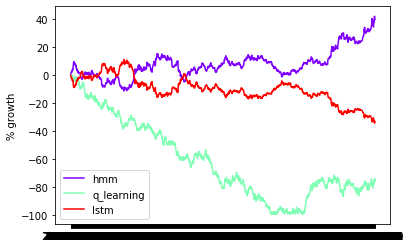

for trading gold hmm yielded 39.77%; q learning yielded -74.32% lstm yielded -33.30%


In [33]:
compare('gold')

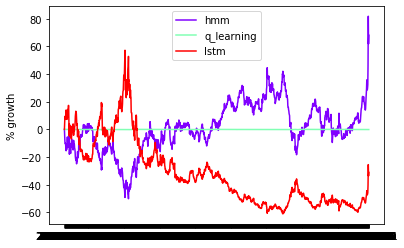

for trading oil hmm yielded 68.08%; q learning yielded -0.12% lstm yielded -31.13%


In [34]:
compare("oil")

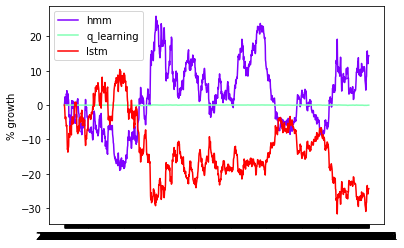

for trading silver hmm yielded 14.36%; q learning yielded -0.04% lstm yielded -24.36%


In [35]:
compare("silver")

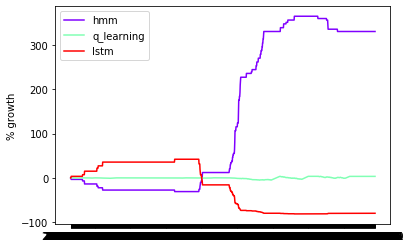

for trading ruth hmm yielded 331.03%; q learning yielded 3.35% lstm yielded -80.09%


In [36]:
compare("ruth")

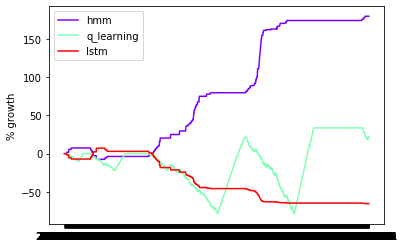

for trading irid hmm yielded 179.63%; q learning yielded 21.67% lstm yielded -65.37%


In [37]:
compare("irid")

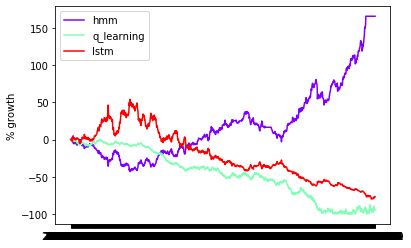

for trading pall hmm yielded 165.48%; q learning yielded -94.73% lstm yielded -76.66%


In [38]:
compare("pall")

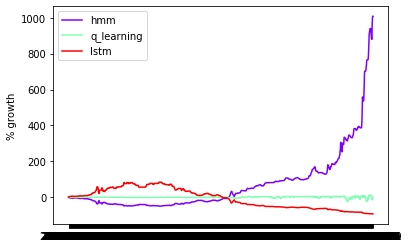

for trading rhod hmm yielded 1008.43%; q learning yielded -0.19% lstm yielded -93.11%


In [39]:
compare("rhod")

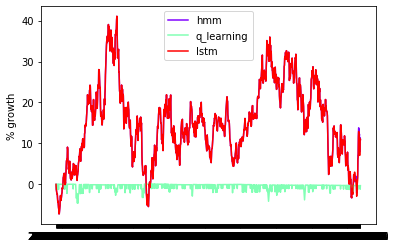

for trading plat hmm yielded 10.89%; q learning yielded -0.30% lstm yielded 11.01%


In [40]:
compare("plat")